In [ ]:
# import wget
# import zipfile
# import os


# testdata = wget.download("https://datasets.tardis.dev/v1/binance/book_snapshot_25/2025/01/01/DOGEUSDT.csv.gz")
# df = pd.read_csv("DOGEUSDT.csv.gz")
# print(df)

# # Path to the downloaded zip file
# zip_file_path = 'DOGEUSDT-trades-2025-01-01.zip'

# # Extract the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # List all files in the zip
#     zip_ref.printdir()

#     # Extract all the contents into the current directory
#     zip_ref.extractall()
    
# path2 = "D:/Documents/CLS/thesis/MM_sandbox/DOGEUSDT-trades-2025-01-01.csv"
# df2 = pd.read_csv(path2)
# print(df2)

# df2 = df2.sort_values("time")
# df2["time"] = pd.to_datetime(df2["time"], unit="ms")

In [1]:
# Packages
from tardis_dev import datasets
import nest_asyncio
import pandas as pd

from hftbacktest.data.utils import tardis
from numba import njit
from hftbacktest import BUY_EVENT
import numpy as np
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest

from matplotlib import pyplot as plt

nest_asyncio.apply()

In [ ]:
# ######## Downloading DOGEUSDT data from Tardis for 2025-01-01 #######
# datasets.download(
#     exchange="binance",
#     data_types=["trades", "incremental_book_L2", "book_snapshot_25"],
#     from_date="2025-01-01",
#     to_date="2025-01-02",   # end date is exclusive
#     symbols=["DOGEUSDT"],
#     # api_key="YOUR_API_KEY",  # omit for 1st-of-month if it works without key
# )

# df1 = pd.read_csv("datasets/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv.gz")
# df2 = pd.read_csv("datasets/binance_incremental_book_L2_2025-01-01_DOGEUSDT.csv.gz")
# df3 = pd.read_csv("datasets/binance_trades_2025-01-01_DOGEUSDT.csv.gz")
# print(df1)
# print(df2)
# print(df3)

In [ ]:
# # Converting tardis data
# tardis.convert(
#     input_files=[
#         "datasets/binance_trades_2025-01-01_DOGEUSDT.csv.gz",
#         "datasets/binance_incremental_book_L2_2025-01-01_DOGEUSDT.csv.gz",
#         "datasets/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv.gz",
#     ],
#     output_filename="data/dogeusdt_20250101.npz",
# )

In [7]:
@njit
def measure_trading_intensity_and_volatility(hbt):
    tick_size = hbt.depth(0).tick_size
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan

    # 100 ms in **nanoseconds** (data timestamps are ns after tardis.convert)
    step_ns = 100_000_000

    while hbt.elapse(step_ns) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(0):
                trade_price_tick = last_trade.px / tick_size

                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = np.nanmax(np.array([trade_price_tick - mid_price_tick, depth]))
                else:
                    depth = np.nanmax(np.array([mid_price_tick - trade_price_tick, depth]))
            arrival_depth[t] = depth

        hbt.clear_last_trades(0)

        depth = hbt.depth(0)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick

        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0

        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick

        t += 1
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception("Preallocated arrays too small")

    return arrival_depth[:t], mid_price_chg[:t]

In [8]:
@njit
def measure_trading_intensity(order_arrival_depth, out):
    """
    Convert a series of order arrival depths (in ticks from mid)
    into a per-distance cumulative trading intensity profile.

    out[i] = number of times a trade occurred within (i+1) ticks of mid.
    """

    max_idx = -1

    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue
        if depth <= 0.0:
            continue

        # depth is typically 0.5, 1.5, 2.5, ... ticks from mid.
        # Map to integer tick distance: 1,2,3,...
        dist_tick = int(np.floor(depth + 0.5))     # 0.5→1, 1.5→2, 2.5→3, ...
        idx = dist_tick - 1                        # 1→0, 2→1, ...

        if idx < 0 or idx >= len(out):
            continue

        # all quotes closer than this tick distance are considered hit
        out[:idx+1] += 1

        if idx > max_idx:
            max_idx = idx

    if max_idx < 0:
        return out[:0]    # no data
    return out[:max_idx+1]

In [9]:
# --- load converted npz ---
feed = np.load("data/dogeusdt_20250101.npz")

# usually the only key is "data", but let's do it generically
data_key = list(feed.files)[0]
data = feed[data_key]

print("data shape:", data.shape)
print("data dtype:", data.dtype)

# --- infer tick size ---

# for v2 hftbacktest, data is a 1-D structured array with a 'px' field
# so we use field access, NOT 2D indexing
prices = data["px"]          # <--- this line is the key change
prices = prices[prices > 0]

unique_px = np.unique(prices)
diffs = np.diff(unique_px)
diffs = diffs[diffs > 0]
tick_size = float(diffs.min())
print("Inferred tick_size:", tick_size)

# --- infer sensible ROI bounds from snapshot mid prices ---
snap = pd.read_csv("datasets/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv.gz")
best_bid = snap["bids[0].price"].to_numpy()
best_ask = snap["asks[0].price"].to_numpy()
mid = 0.5 * (best_bid + best_ask)
mid = mid[~np.isnan(mid)]

px_min = mid.min()
px_max = mid.max()
margin = 0.2   # 20% margin around min/max
roi_lb = max(0.0, px_min * (1 - margin))
roi_ub = px_max * (1 + margin)

print("mid min/max:", px_min, px_max)
print("roi_lb:", roi_lb, "roi_ub:", roi_ub)

data shape: (8754190,)
data dtype: [('ev', '<u8'), ('exch_ts', '<i8'), ('local_ts', '<i8'), ('px', '<f8'), ('qty', '<f8'), ('order_id', '<u8'), ('ival', '<i8'), ('fval', '<f8')]
Inferred tick_size: 9.99999999995449e-06
mid min/max: 0.311955 0.327485
roi_lb: 0.249564 roi_ub: 0.392982


In [11]:
asset = (
    BacktestAsset()
        .data([
            'data/dogeusdt_20250101.npz'
        ])
        # .initial_snapshot('data/dogeusdt_20250101_eod.npz')  # optional if you later build it
        .linear_asset(1.0)
        # .intp_order_latency(['latency/feed_latency_20250101.npz'])  # optional
        .power_prob_queue_model(2.0)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(tick_size)   # <-- inferred above, ~1e-5
        .lot_size(0.001)        # rough; you can refine with LOT_SIZE rules
        .roi_lb(roi_lb)         # <-- from mid range
        .roi_ub(roi_ub)
        .last_trades_capacity(10_000)
)

hbt = ROIVectorMarketDepthBacktest([asset])

arrival_depth, mid_price_chg = measure_trading_intensity_and_volatility(hbt)

hbt.close()

0

In [12]:
finite_mask = np.isfinite(arrival_depth)
print("Total points:", len(arrival_depth))
print("Finite depths:", finite_mask.sum())

finite_depths = arrival_depth[finite_mask]
print("Finite depth min/max:", finite_depths.min(), finite_depths.max())

Total points: 863990
Finite depths: 129159
Finite depth min/max: -36.500000148244 31601.500000143817


In [14]:
tmp = np.zeros(2000, np.float64)

# use full available window
window_steps = len(arrival_depth)

lambda_ = measure_trading_intensity(arrival_depth[:window_steps], tmp)

# per second: each step is 100 ms => 10 steps per second
lambda_ = lambda_ / (window_steps / 10.0)

# δ (distance from mid) in ticks: 1,2,3,...
ticks = np.arange(1, len(lambda_) + 1, dtype=np.float64)

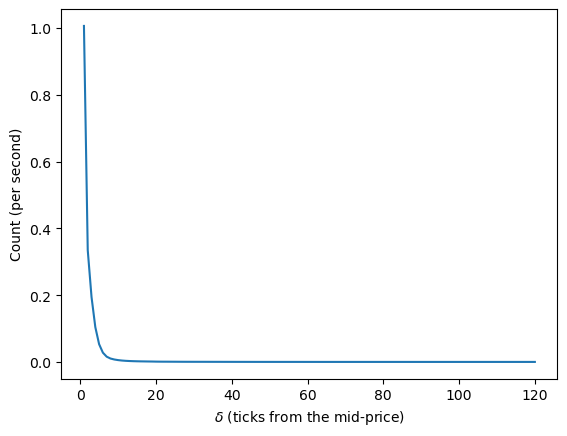

In [15]:
plt.plot(ticks, lambda_)
plt.xlabel('$ \\delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')
plt.show()

In [16]:
@njit
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept

In [17]:
# restrict to first N ticks to avoid noisy far tail
N = min(70, len(lambda_))
lambda_head = lambda_[:N]
ticks_head = ticks[:N]

# keep only positive intensities
mask = lambda_head > 0
x = ticks_head[mask]
y = np.log(lambda_head[mask])

if len(x) < 3:
    raise ValueError("Not enough non-zero λ bins to calibrate A and k")

k_, logA = linear_regression(x, y)
A = np.exp(logA)
k = -k_

print(f"A = {A}, k = {k}")

A = 0.02158345649646689, k = 0.10914307696621414


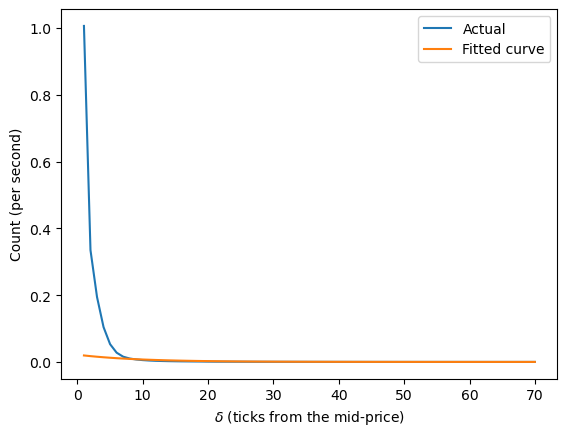

In [18]:
plt.plot(ticks_head, lambda_head, label="Actual")
plt.plot(ticks_head, A * np.exp(-k * ticks_head), label="Fitted curve")
plt.xlabel('$ \\delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')
plt.legend()
plt.show()

In [19]:
# Refits for the range un to 70 ticks.
x_shallow = ticks[:4]
lambda_shallow = lambda_[:4]

y = np.log(lambda_shallow)
k_, logA = linear_regression(x_shallow, y)
A = np.exp(logA)
k = -k_

print('A={}, k={}'.format(A, k))

A=1.8036957622055092, k=0.7346097197108143


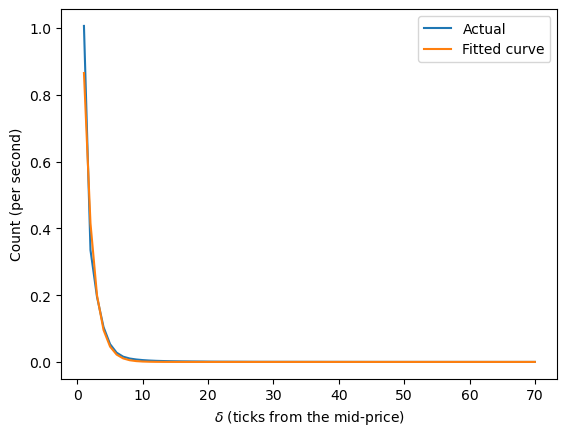

In [20]:
plt.plot(ticks_head, lambda_head, label="Actual")
plt.plot(ticks_head, A * np.exp(-k * ticks_head), label="Fitted curve")
plt.xlabel('$ \\delta $ (ticks from the mid-price)')
plt.ylabel('Count (per second)')
plt.legend()
plt.show()

Number of bins used for fit: 10
Near-range fit: A = 1.129602886069239 k = 0.574409268677215


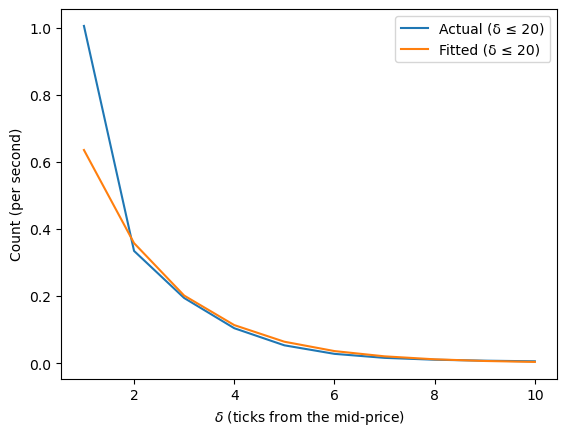

In [28]:
# choose head range for calibration
delta_max = 10               # or 15, or whatever range you care about
mask_range = (ticks <= delta_max)

lambda_head = lambda_[mask_range]
ticks_head = ticks[mask_range]

# keep only positive λ
mask_pos = lambda_head > 0
x = ticks_head[mask_pos]
y = np.log(lambda_head[mask_pos])

print("Number of bins used for fit:", len(x))
if len(x) < 3:
    raise ValueError("Not enough non-zero λ bins to calibrate A and k")

# simple linear regression in log-space
k_, logA = linear_regression(x, y)
A_near = np.exp(logA)
k_near = -k_

print("Near-range fit: A =", A_near, "k =", k_near)

# plot comparison
plt.plot(ticks_head, lambda_head, label="Actual (δ ≤ 20)")
plt.plot(ticks_head, A_near * np.exp(-k_near * ticks_head), label="Fitted (δ ≤ 20)")
plt.xlabel(r"$\delta$ (ticks from the mid-price)")
plt.ylabel("Count (per second)")
plt.legend()
plt.show()


Weighted near-range fit: A = 1.833872503969443 k = 0.7054706140489642


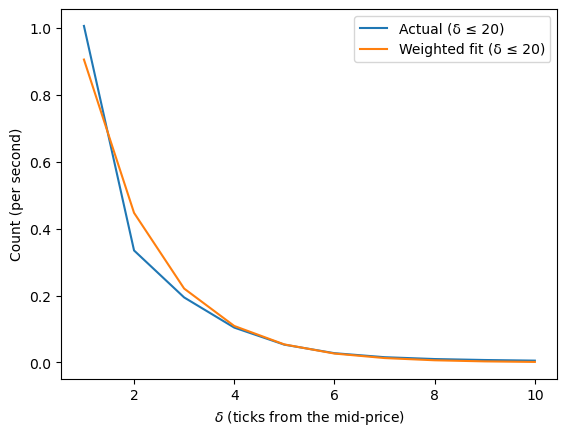

In [29]:
# weighted linear regression: weights = λ
w = lambda_head[mask_pos]
xw = x
yw = y

sw  = np.sum(w)
swx = np.sum(w * xw)
swy = np.sum(w * yw)
swx2 = np.sum(w * xw * xw)
swxy = np.sum(w * xw * yw)

den = sw * swx2 - swx * swx
slope = (sw * swxy - swx * swy) / den
intercept = (swy - slope * swx) / sw

k_w = -slope
A_w = np.exp(intercept)

print("Weighted near-range fit: A =", A_w, "k =", k_w)

plt.plot(ticks_head, lambda_head, label="Actual (δ ≤ 20)")
plt.plot(ticks_head, A_w * np.exp(-k_w * ticks_head), label="Weighted fit (δ ≤ 20)")
plt.xlabel(r"$\delta$ (ticks from the mid-price)")
plt.ylabel("Count (per second)")
plt.legend()
plt.show()


In [21]:
# mid_price_chg is in ticks per 100 ms
# 100 ms = 0.1 s → 10 samples per second
volatility = np.nanstd(mid_price_chg) * np.sqrt(10)
print("Volatility (ticks / sqrt(sec)):", volatility)

Volatility (ticks / sqrt(sec)): 107.52906361770927


In [22]:
print("sigma =", volatility)
print("A =", A, "k =", k)
print("len(lambda_):", len(lambda_))
print("lambda_[:10]:", lambda_[:10])

sigma = 107.52906361770927
A = 1.8036957622055092 k = 0.7346097197108143
len(lambda_): 120
lambda_[:10]: [1.00627322 0.33486499 0.19441197 0.10422574 0.05316034 0.02769708
 0.01571777 0.01019688 0.0073149  0.00546303]
